In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define psf

In [2]:
from __future__ import annotations

import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def _ensure_1d(x: ArrayLike) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.ndim == 0:
        x = x[None]
    if x.ndim != 1:
        raise ValueError("Input must be 1D (or scalar).")
    return x


def _trapz_weights_1d(x: np.ndarray) -> np.ndarray:
    """
    Trapezoidal quadrature weights w such that sum_j f(x_j) w_j ≈ ∫ f(x) dx.
    """
    x = _ensure_1d(x)
    n = x.size
    if n == 1:
        return np.array([1.0], dtype=float)

    dx = np.diff(x)
    if np.any(dx <= 0):
        raise ValueError("Grid must be strictly increasing.")

    w = np.empty(n, dtype=float)
    w[0] = 0.5 * dx[0]
    w[-1] = 0.5 * dx[-1]
    w[1:-1] = 0.5 * (dx[:-1] + dx[1:])
    return w


def renormalize_rows(R: np.ndarray, q_grid: np.ndarray) -> np.ndarray:
    """
    Enforce (numerically) ∫ R(Q_i, q) dq = 1 for each row i, using trapz weights.
    """
    q = _ensure_1d(q_grid)
    w = _trapz_weights_1d(q)  # (M_mod,)
    row_mass = R @ w          # (M_obs,)
    # Avoid division by zero for rows with zero support
    scale = np.where(row_mass > 0, 1.0 / row_mass, 1.0)
    return R * scale[:, None]


def _gaussian_smoother(grid: np.ndarray, mu: float) -> Optional[np.ndarray]:
    """
    Column-stochastic Gaussian smoother S so that y_sm ≈ S @ y.
    If mu <= 0, returns None.
    """
    if mu is None or mu <= 0:
        return None
    x = _ensure_1d(grid)
    dx_min = np.min(np.diff(x)) if x.size > 1 else 1.0
    mu_eff = max(mu, 0.5 * dx_min)

    X = x[:, None]
    Y = x[None, :]
    K = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
    K /= np.maximum(K.sum(axis=1, keepdims=True), 1e-300)
    return K


def _slit_params(Q: np.ndarray, epsilon: float, phi: Literal[0, "0", "parallel", "pi/2", "perp", 1]) -> tuple[np.ndarray, float, float]:
    """
    Returns:
      Qeff(Q): effective lower-bound location of the integrable singularity.
      qmax(Q): upper support bound.
      pref:  overall prefactor multiplying q/sqrt(q^2 - Qeff^2).
    """
    Q = _ensure_1d(Q)
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1+epsilon > 0.")

    if phi in (0, "0", "parallel"):
        # Case I: phi = 0 (strain axis parallel to slit)
        # R = ((1+eps)/sigma_y) * q / sqrt(q^2 - Q^2)
        # support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+eps))^2)
        Qeff = Q
        pref = (1.0 + epsilon)  # /sigma_y handled later
        # qmax depends on sigma_y too -> computed outside with sigma_y
        # We'll return factor to build qmax: sqrt(Q^2 + (sigma_y/(1+eps))^2)
        return Qeff, pref, 0.0  # placeholder for case flag
    elif phi in ("pi/2", "perp", 1):
        # Case II: phi = pi/2 (strain axis perpendicular to slit)
        # R = (1/sigma_y) * q / sqrt(q^2 - (Q/(1+eps))^2)
        # support: Q/(1+eps) <= q <= sqrt((Q/(1+eps))^2 + sigma_y^2)
        Qeff = Q / (1.0 + epsilon)
        pref = 1.0  # /sigma_y handled later
        return Qeff, pref, 1.0  # placeholder for case flag
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")


# -----------------------------------------------------------------------------
# 1) Definition-based anisotropic slit PSF (phi = 0 or pi/2 only)
# -----------------------------------------------------------------------------

def R_slit_aniso(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    eps_reg: float = 1e-15,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    Orientation-resolved *anisotropic* slit PSF for the two special cases:

    Case I (phi = 0, "parallel"):
        R_slit(Q,q) = (1+epsilon)/sigma_y * q / sqrt(q^2 - Q^2),
        support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+epsilon))^2).

    Case II (phi = pi/2, "perp"):
        R_slit(Q,q) = 1/sigma_y * q / sqrt(q^2 - (Q/(1+epsilon))^2),
        support: Q/(1+epsilon) <= q <= sqrt((Q/(1+epsilon))^2 + sigma_y^2).

    Parameters
    ----------
    Q_obs : (M_obs,) array
        Observed horizontal momentum transfers Q (assumed nonnegative).
    q_mod : (M_mod,) array
        Model grid q where latent intensity I(q) is defined.
    sigma_y : float
        Half slit width in Q_y units.
    epsilon : float
        Affine strain parameter (requires 1+epsilon > 0).
    phi : {0, "parallel", "pi/2", "perp"}
        Only these two orientations are supported.
    mu_q : float
        Optional Gaussian smoothing along q_mod (right-multiply by S^T).
    eps_reg : float
        Small regularization added under sqrt to avoid division by zero at the
        integrable singularity when sampled exactly on-grid.
    renormalize : bool
        If True, normalize each row so ∫ R(Q_i,q) dq ≈ 1.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if np.any(q <= 0):
        # not strictly required, but typical for scattering q-grid
        pass

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # Build qmax for each Q
    if case_flag == 0.0:
        # phi = 0: qmax = sqrt(Q^2 + (sigma_y/(1+eps))^2)
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        # phi = pi/2: qmax = sqrt((Q/(1+eps))^2 + sigma_y^2)
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    # Broadcast to (M_obs, M_mod)
    Qeff_mat = Qeff[:, None]
    qmax_mat = qmax[:, None]
    q_row = q[None, :]

    support = (q_row >= Qeff_mat) & (q_row <= qmax_mat)

    denom_sq = q_row**2 - Qeff_mat**2
    denom = np.sqrt(np.maximum(denom_sq, 0.0) + eps_reg**2)

    with np.errstate(divide="ignore", invalid="ignore"):
        base = (pref / sigma_y) * (q_row / denom)
        R = np.where(support, base, 0.0)

    # Optional smoothing along q (right-multiply by S^T)
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R


# -----------------------------------------------------------------------------
# 2) Thin-rectangle (bin-averaged) approximation to remove sampled singularity
# -----------------------------------------------------------------------------

def R_slit_aniso_rect(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    thin_dq: Optional[float] = None,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    "Very thin rectangular slit" approximation in q to avoid the pointwise
    integrable singularity at q = Q_eff by *cell-averaging* each q-bin.

    Uses the analytic identity:
        ∫ q / sqrt(q^2 - a^2) dq = sqrt(q^2 - a^2).

    For each observed Q_i and each bin [L_k, U_k] (a thin rectangle in q),
    we compute:
        (1/Δq_k) ∫_{intersection} pref/sigma_y * q/sqrt(q^2-a^2) dq
      = pref/sigma_y * ( sqrt(U^2-a^2) - sqrt(L^2-a^2) ) / Δq_k,
    where a = Q_eff(Q_i) and the intersection is further limited to the support
    [Q_eff, qmax].

    Parameters
    ----------
    Q_obs, q_mod, sigma_y, epsilon, phi, mu_q, renormalize :
        Same meaning as in `R_slit_aniso`.
    thin_dq : float or None
        If None: use bin edges inferred from q_mod (midpoints).
        If provided: use a uniform "thin rectangle" width thin_dq centered at
        each q_mod[k], i.e. [q_k - thin_dq/2, q_k + thin_dq/2].

    Returns
    -------
    R : (M_obs, M_mod) array
        Bin-averaged kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if q.size < 2 and thin_dq is None:
        raise ValueError("q_mod must have at least 2 points if thin_dq is None.")
    if thin_dq is not None and thin_dq <= 0:
        raise ValueError("thin_dq must be positive if provided.")

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # qmax for each Q
    if case_flag == 0.0:
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    M_obs, M_mod = Q.size, q.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # Build "thin rectangle" bins in q
    if thin_dq is None:
        edges = np.empty(M_mod + 1, dtype=float)
        edges[1:-1] = 0.5 * (q[1:] + q[:-1])
        edges[0] = q[0] - 0.5 * (q[1] - q[0])
        edges[-1] = q[-1] + 0.5 * (q[-1] - q[-2])
        L0 = edges[:-1]  # (M_mod,)
        U0 = edges[1:]   # (M_mod,)
        dQ = U0 - L0
    else:
        half = 0.5 * thin_dq
        L0 = q - half
        U0 = q + half
        dQ = np.full_like(q, thin_dq, dtype=float)

    # Row-by-row (broadcast-friendly over bins)
    for i in range(M_obs):
        a = Qeff[i]
        b = qmax[i]

        # Intersect each bin with the admissible support [a, b]
        L = np.maximum(L0, a)
        U = np.minimum(U0, b)
        valid = U > L

        if not np.any(valid):
            continue

        # Compute sqrt(U^2-a^2) - sqrt(L^2-a^2)
        # Note: L,U >= a by construction in the valid set.
        termU = np.sqrt(np.maximum(U[valid] ** 2 - a * a, 0.0))
        termL = np.sqrt(np.maximum(L[valid] ** 2 - a * a, 0.0))

        r_line = np.zeros(M_mod, dtype=float)
        r_line[valid] = (pref / sigma_y) * (termU - termL) / dQ[valid]
        R[i, :] = r_line

    # Optional smoothing along q
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R



## isotropic psf

In [3]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


In [57]:
import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


def f_I_phi(
    Q: ArrayLike,
    I_iso: ArrayLike,
    *,
    epsilon: float,
    phi: Literal[0, "0", "parallel", "pi/2", "perp"] = 0,
    mu_q: float = 0.0,
    kind: Optional[str] = "linear",
    powerlaw_nfit: int = 8,
    powerlaw_floor: float = 1e-300,
) -> np.ndarray:
    r"""
    Directional *true* spectrum I_phi(Q) from isotropic I_iso(q) under affine strain,
    for phi = 0 and phi = pi/2, with optional *power-law extrapolation* at both ends.

    Mapping:
      - phi = 0      : q = Q                 => I_phi(Q) = I_iso(Q)
      - phi = pi/2   : q = Q/(1+epsilon)     => I_phi(Q) = I_iso(Q/(1+epsilon))

    Extrapolation:
      If `kind is not None`, extrapolate outside the tabulated Q-range using power laws
      fitted on log-log to the first/last `powerlaw_nfit` points.

    Parameters
    ----------
    Q : (N,) array
        Grid where I_iso is sampled (also used as the q-grid for I_iso(q)).
    I_iso : (N,) array
        Isotropic spectrum sampled on Q-grid.
    epsilon : float
        Affine strain parameter, requires 1+epsilon > 0.
    phi : {0, "parallel", "pi/2", "perp"}
        Special orientations supported.
    mu_q : float
        Optional Gaussian smoothing applied after resampling (in Q-space).
    kind : str or None
        If None: out-of-range values are set to 0.
        If not None: inside-range uses np.interp (linear), outside-range uses power-law extrap.
    powerlaw_nfit : int
        Number of points to fit each end power law (clipped to [2, N]).
    powerlaw_floor : float
        Floor to avoid log(0) during power-law fitting.

    Returns
    -------
    I_phi : (N,) array
        Directional (true) spectrum on the input Q grid.
    """
    Q = np.asarray(Q, dtype=float)
    I_iso = np.asarray(I_iso, dtype=float)
    if Q.ndim != 1 or I_iso.ndim != 1 or Q.size != I_iso.size:
        raise ValueError("Q and I_iso must be 1D arrays of the same length.")
    if Q.size < 2:
        raise ValueError("Q must have at least 2 points.")
    if np.any(np.diff(Q) <= 0):
        raise ValueError("Q must be strictly increasing.")
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1 + epsilon > 0.")

    # --- affine mapping q(Q; phi) ---
    if phi in (0, "0", "parallel"):
        q_eval = Q.copy()
    elif phi in ("pi/2", "perp"):
        q_eval = Q / (1.0 + epsilon)
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")

    Qmin, Qmax = Q[0], Q[-1]

    # --- interpolation + (optional) power-law extrapolation ---
    if kind is None:
        I_phi = np.interp(q_eval, Q, I_iso, left=0.0, right=0.0)
    else:
        # Inside-range interpolation
        I_phi = np.interp(q_eval, Q, I_iso)  # no left/right fill yet

        # Fit power laws on both ends in log-log: log I = a + b log Q  => I = exp(a) Q^b
        nfit = int(np.clip(powerlaw_nfit, 2, Q.size))

        def _fit_powerlaw(Q_fit: np.ndarray, I_fit: np.ndarray) -> tuple[float, float]:
            # returns (a, b) for log I = a + b log Q
            I_pos = np.maximum(I_fit, powerlaw_floor)
            x = np.log(Q_fit)
            y = np.log(I_pos)
            b, a = np.polyfit(x, y, deg=1)
            return float(a), float(b)

        aL, bL = _fit_powerlaw(Q[:nfit], I_iso[:nfit])
        aR, bR = _fit_powerlaw(Q[-nfit:], I_iso[-nfit:])

        left_mask = q_eval < Qmin
        right_mask = q_eval > Qmax

        if np.any(left_mask):
            qL = np.maximum(q_eval[left_mask], powerlaw_floor)
            I_phi[left_mask] = np.exp(aL) * (qL ** bL)

        if np.any(right_mask):
            qR = np.maximum(q_eval[right_mask], powerlaw_floor)
            I_phi[right_mask] = np.exp(aR) * (qR ** bR)

    # --- optional Gaussian smoothing in Q-space ---
    if mu_q and mu_q > 0:
        dQ_min = np.min(np.diff(Q))
        mu_eff = max(float(mu_q), 0.5 * float(dQ_min))
        X = Q[:, None]
        Y = Q[None, :]
        G = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
        G /= np.maximum(G.sum(axis=1, keepdims=True), 1e-300)
        I_phi = G @ I_phi

    return I_phi


## test psf

In [58]:
from scipy.special import sici as sici
def S_rod(q,L):
    y = 2*sici(q*L)[0]/(q*L) - 4*np.sin(q*L/2)**2/(q*L)**2

    return y  

In [85]:
Q_min = 5e-5
Q_max = 0.2
# Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 200)  # experimental Q

I_iso = S_rod(Q_sampled,1000)
epsilon = 0.2
sigma_y = 0.1

# ---------------------------------------------------------------------
# Build anisotropic slit PSF and smear I_iso (following *exactly* your pattern)
# ---------------------------------------------------------------------

# Choose orientation: phi = 0 (parallel) or phi = "pi/2" (perpendicular)
phi = 0  # or "pi/2"

# --- Forward smearing operator: R_raw (UN-normalized) ---

I_smeared_list = []
I_phi_parallel_list = []
I_phi_perp_list = []
epsilon_list = [0.0, 0.2, 0.5, 1.0]
for epsilon in epsilon_list:
    R_raw = R_slit_aniso_rect(
        Q_obs=Q_sampled,
        q_mod=Q_sampled,      # latent grid = same as sampled grid here
        sigma_y=sigma_y,
        epsilon=epsilon,
        phi=phi,
        mu_q=0.0,
    )                         # shape (N_obs, N_lat)

    def f_smear(R_raw, I_lat, Q_lat):
        w = np.zeros_like(Q_lat)
        w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
        w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
        w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
        num = R_raw * w[None, :]
        row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
        R_mat = num / row_sum
        return R_mat @ I_lat, R_mat

    I_smeared, R = f_smear(R_raw, I_iso, Q_sampled)
    I_smeared_list.append(I_smeared)
    
    I_phi_parallel = f_I_phi(
        Q=Q_sampled,
        I_iso=I_iso,
        epsilon=epsilon,
        phi="0",
        mu_q=0.0,
        kind="linear",
    )
    I_phi_parallel_list.append(I_phi_parallel)
    I_phi_perp = f_I_phi(
        Q=Q_sampled,
        I_iso=I_iso,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
        kind="linear",
    )
    I_phi_perp_list.append(I_phi_perp)
    
# Use rectangular (bin-averaged) version to avoid singularity
R_raw = R_slit_aniso_rect(
    Q_obs=Q_sampled,
    q_mod=Q_sampled,      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)

def f_smear(R_raw, I_lat, Q_lat):
    w = np.zeros_like(Q_lat)
    w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
    w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
    w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
    num = R_raw * w[None, :]
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    R_mat = num / row_sum
    return R_mat @ I_lat, R_mat

I_smeared, R = f_smear(R_raw, I_iso, Q_sampled)

R_raw_iso = R_rect(
    Qx_obs=Q_sampled,
    Q_mod=Q_sampled,
    sigma_x=sigma_y*1e-7,
    sigma_y=sigma_y,
    nx=64,
    mu_Q=0.0,
    cell_average=True,
)

I_smeared_iso, R_iso = f_smear(R_raw_iso, I_iso, Q_sampled)

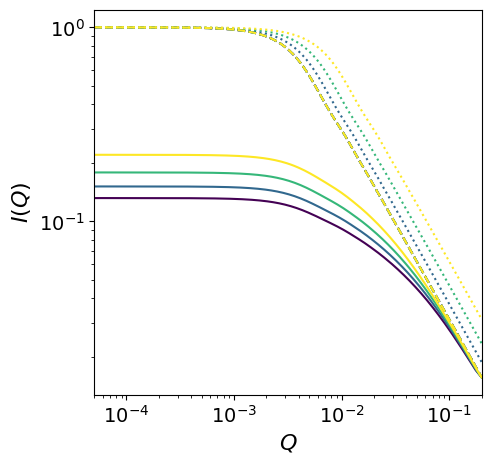

In [86]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(Q_sampled, I_iso, label=r'$I_\mathrm{iso}(q)$', color='blue')

for iepsilon, I_smeared in enumerate(I_smeared_list):
    color = plt.cm.viridis(iepsilon / (len(epsilon_list)-1))
    ax.plot(Q_sampled, I_smeared, label=rf'$\epsilon={epsilon_list[iepsilon]}$', linestyle='-', color=color)
    ax.plot(Q_sampled, I_phi_parallel_list[iepsilon], label=r'$I_{\parallel}(Q)$', color=color, linestyle='--')
    ax.plot(Q_sampled, I_phi_perp_list[iepsilon], label=r'$I_{\perp}(Q)$', color=color, linestyle=':')
# ax.plot(Q_sampled, I_smeared_iso, label=r'Isotropic Smeared $I(q)$', color='r', linestyle='--')

ax.set_xlim(Q_min, Q_max)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
# ax.legend(fontsize=10, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=14)

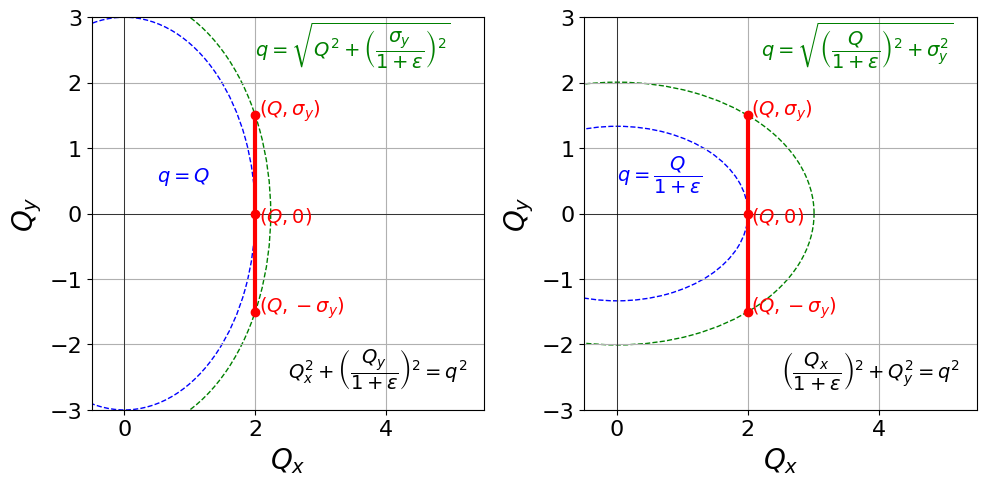

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ---------- Common parameters ----------
Qx_val = 2.0
sigma_y_val = 1.5
epsilon = 0.5
s = 1.0 + epsilon
Qy_sample = 1.0

# ---------- Helper to draw ellipse arcs ----------
def draw_ellipse_arc(ax, a_x, a_y, theta_max, color, ls, lw=1):
    arc = patches.Arc(
        (0, 0),
        2 * a_x,
        2 * a_y,
        theta1=0,
        theta2=theta_max,
        color=color,
        ls=ls,
        lw=lw,
    )
    ax.add_patch(arc)

# ==================== Parallel case ====================
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

ax.axhline(0, color="black", lw=0.5)
ax.axvline(0, color="black", lw=0.5)

# Slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], "r-", lw=3)

# Slit points
ax.plot([Qx_val], [0], "ro")
ax.plot([Qx_val], [sigma_y_val], "ro")
ax.plot([Qx_val], [-sigma_y_val], "ro")

ax.text(Qx_val + 0.05, -0.12, r"$(Q,0)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, sigma_y_val, r"$(Q,\sigma_y)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, -sigma_y_val, r"$(Q,-\sigma_y)$", fontsize=14, color="r")

# Blue ellipse: q^2 = Q_x^2 + (Q_y/(1+epsilon))^2 = Q^2
draw_ellipse_arc(ax, Qx_val, s * Qx_val, 360, "blue", "--")
ax.text(0.5, 0.5, r"$q = Q$",
        color="blue", fontsize=14)

# Green ellipse: q^2 = Q_x^2 + (Q_y/(1+epsilon))^2 = Q^2 + (\sigma_y/(1+\epsilon))^2
q_max_par = np.sqrt(Qx_val**2 + (sigma_y_val / s) ** 2)
draw_ellipse_arc(ax, q_max_par, s * q_max_par, 360, "green", "--")
ax.text(2, 2.4,
        r"$q = \sqrt{Q^2 + \left(\dfrac{\sigma_y}{1+\epsilon}\right)^2}$",
        color="green", fontsize=14)

# # Sample point
# ax.plot([Qx_val], [Qy_sample], "ko")
# ax.text(Qx_val + 0.05, Qy_sample, r"$(Q,Q_y)$", fontsize=14)
ax.text(2.5,-2.5, r"$Q_x^2 + \left(\dfrac{Q_y}{1+\epsilon}\right)^2 = q^2$", fontsize=14)

# Formatting
ax.set_xlabel(r"$Q_x$", fontsize=20)
ax.set_ylabel(r"$Q_y$", fontsize=20)
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-3, 3)
ax.set_aspect("equal", adjustable="box")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True)

# ==================== Perpendicular case ====================
ax = fig.add_subplot(1, 2, 2)

ax.axhline(0, color="black", lw=0.5)
ax.axvline(0, color="black", lw=0.5)

# Slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], "r-", lw=3)

# Slit points
ax.plot([Qx_val], [0], "ro")
ax.plot([Qx_val], [sigma_y_val], "ro")
ax.plot([Qx_val], [-sigma_y_val], "ro")

ax.text(Qx_val + 0.05, -0.12, r"$(Q,0)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, sigma_y_val, r"$(Q,\sigma_y)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, -sigma_y_val, r"$(Q,-\sigma_y)$", fontsize=14, color="r")

# Blue ellipse: q^2 = (Q_x/(1+epsilon))^2 + Q_y^2 = (Q/(1+epsilon))^2
q_min_perp = Qx_val / s
draw_ellipse_arc(ax, s * q_min_perp, q_min_perp, 360, "blue", "--")
ax.text(0, 0.5,
        r"$q = \dfrac{Q}{1+\epsilon}$",
        color="blue", fontsize=14)

# Green ellipse: q^2 = (Q_x/(1+epsilon))^2 + Q_y^2 = (Q/(1+epsilon))^2 + \sigma_y^2
q_max_perp = np.sqrt((Qx_val / s) ** 2 + sigma_y_val**2)
draw_ellipse_arc(ax, s * q_max_perp, q_max_perp, 360, "green", "--")
ax.text(2.2, 2.4,
        r"$q = \sqrt{\left(\dfrac{Q}{1+\epsilon}\right)^2 + \sigma_y^2}$",
        color="green", fontsize=14)

# # Sample point
# ax.plot([Qx_val], [Qy_sample], "ko")
# ax.text(Qx_val + 0.05, Qy_sample, r"$(Q,Q_y)$", fontsize=14)
ax.text(2.5,-2.5, r"$\left(\dfrac{Q_x}{1+\epsilon}\right)^2 + Q_y^2 = q^2$", fontsize=14)

# Formatting
ax.set_xlabel(r"$Q_x$", fontsize=20)
ax.set_ylabel(r"$Q_y$", fontsize=20)
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-3, 3)
ax.set_aspect("equal", adjustable="box")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True)

plt.tight_layout()
plt.show()
